# walmart-weekly-sale-forecast

Use the "Run" button to execute the code.

# Install and importing libraries
Required libraries for performing various data related operations are to be installed and imported.

In [ ]:
!pip install jovian opendatasets numpy pandas-profiling matplotlib seaborn --quiet

     |████████████████████████████████| 68 kB 3.0 MB/s 


In [ ]:
!pip install xgboost scikit-learn --upgrade --quiet

     |████████████████████████████████| 255.9 MB 39 kB/s 


In [ ]:
import os
import opendatasets as od
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)

# Downloading and Data extraction
Choosen dataset is downloaded using opendatasets library and kaggle key

In [ ]:
od.download('https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: bandarisaidrupadh
Your Kaggle Key: ··········


100%|██████████| 2.70M/2.70M [00:00<00:00, 62.5MB/s]


Extracting archive ./walmart-recruiting-store-sales-forecasting/walmart-recruiting-store-sales-forecasting.zip to ./walmart-recruiting-store-sales-forecasting


In [ ]:
os.listdir('walmart-recruiting-store-sales-forecasting')

['train.csv.zip',
 'test.csv.zip',
 'features.csv.zip',
 'sampleSubmission.csv.zip',
 'stores.csv']

In [ ]:
pip install zipfile36 --quiet

In [ ]:
wall_df = pd.read_csv('./walmart-recruiting-store-sales-forecasting/train.csv.zip', low_memory=False,compression='zip')
store_df = pd.read_csv('./walmart-recruiting-store-sales-forecasting/stores.csv')
features_df=pd.read_csv('./walmart-recruiting-store-sales-forecasting/features.csv.zip',compression='zip')
test_df = pd.read_csv('./walmart-recruiting-store-sales-forecasting/test.csv.zip',compression='zip')
submission_df = pd.read_csv('./walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip',compression = 'zip')


# Data wrangling
Multiple datasets are merged eliminating errored entries to ease exploratory data analysis

In [ ]:
train_df = wall_df.merge(store_df, how='left', on='Store')

In [ ]:
train_features_df = train_df.merge(features_df,how = 'left',on = ['Store','Date','IsHoliday'])


In [ ]:
test_df = test_df.merge(store_df,how='left',on = 'Store')

In [ ]:
test_feature_df = test_df.merge(features_df,how = 'left',on = ['Store','Date','IsHoliday'])

In [ ]:
def date_split(df):
  df['Date'] = pd.to_datetime(df['Date'])
  df['Year'] = df.Date.dt.year
  df['Month'] = df.Date.dt.month
  df['Week'] = df['Date'].dt.isocalendar().week

In [ ]:
date_split(train_features_df)
date_split(test_feature_df)
def week_of_month(dates):
    
    firstday_in_month = dates - pd.to_timedelta(dates.dt.day - 1, unit='d')
    return (dates.dt.day-1 + firstday_in_month.dt.weekday) // 7 + 1
    

In [ ]:
train_features_df['wom']=week_of_month(train_features_df['Date'])
test_feature_df['wom']=week_of_month(test_feature_df['Date'])

In [ ]:
df1= train_features_df.copy()
df2= df1[df1['Weekly_Sales']<0]
df2 = df1.drop(df2.index,axis=0).reset_index()
df2.describe()

,index,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Week,wom
count,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,150200.000000,110918.000000,136667.000000,134535.000000,150948.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000
mean,210733.127854,22.195477,44.242771,16030.329773,136749.569176,60.090474,3.360888,7247.781936,3329.917771,1441.588079,3384.718610,4629.478027,171.212152,7.960077,2010.968443,6.449709,25.827729,2.943250
std,121716.724012,12.787213,30.507197,22728.500149,60992.688568,18.448260,0.458523,8292.900915,9459.871787,9631.415934,6294.807678,5959.849053,39.162280,1.863873,0.796893,3.243394,14.152442,1.299097
min,0.000000,1.000000,1.000000,0.000000,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,2010.000000,1.000000,1.000000,1.000000
25%,105306.000000,11.000000,18.000000,2117.560000,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.100000,504.220000,1878.440000,132.022667,6.891000,2010.000000,4.000000,14.000000,2.000000
50%,210763.000000,22.000000,37.000000,7659.090000,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.350989,7.866000,2011.000000,6.000000,26.000000,3.000000
75%,316110.000000,33.000000,74.000000,20268.380000,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.445487,8.567000,2012.000000,9.000000,38.000000,4.000000
max,421569.000000,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,2012.000000,12.000000,52.000000,5.000000


In [ ]:
test_feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         115064 non-null  int64         
 1   Dept          115064 non-null  int64         
 2   Date          115064 non-null  datetime64[ns]
 3   IsHoliday     115064 non-null  bool          
 4   Type          115064 non-null  object        
 5   Size          115064 non-null  int64         
 6   Temperature   115064 non-null  float64       
 7   Fuel_Price    115064 non-null  float64       
 8   MarkDown1     114915 non-null  float64       
 9   MarkDown2     86437 non-null   float64       
 10  MarkDown3     105235 non-null  float64       
 11  MarkDown4     102176 non-null  float64       
 12  MarkDown5     115064 non-null  float64       
 13  CPI           76902 non-null   float64       
 14  Unemployment  76902 non-null   float64       
 15  Year          115

# Exploratory Data Analysis (EDA)
Explore the data to understand relationship between different features their distributions to provide insight for further machine learning model development.

In [ ]:
import plotly.express as px
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df_1=df2.groupby(['Year','Month'])['Weekly_Sales'].sum().reset_index()
df_1['Year'] = df_1['Year'].astype(str)
px.bar(df_1,x='Month',y='Weekly_Sales',color='Year',barmode='group')

Insights:
From weekly sale distribution in each month of year,it can be observed that sales peakmin 12th month of the year drastically.For the rest of the months sales are almost similar with some random peaks which should be further analysed.

In [ ]:
df_2= df2.groupby(['Year','Month','wom'])['Weekly_Sales'].agg(['min','mean','max','sum']).reset_index()
df_2['wom'] = df_2['wom'].astype(str)
px.box(df_2,x='Year',y='sum',color='wom',boxmode='group')

Insights: Weekly sales distribution for week in month sales shows that spending decreases with progression of week in a month but there are some outliers might be due to holiday season in later parts of the month. 

In [ ]:
WS_10 = df2.loc[df2['Year']==2010].groupby(['Week']).agg({'Weekly_Sales': ['mean']})
WS_11 = df2.loc[df2['Year']==2011].groupby(['Week']).agg({'Weekly_Sales': ['mean']})
WS_12 = df2.loc[df2['Year']==2012].groupby(['Week']).agg({'Weekly_Sales': ['mean']})

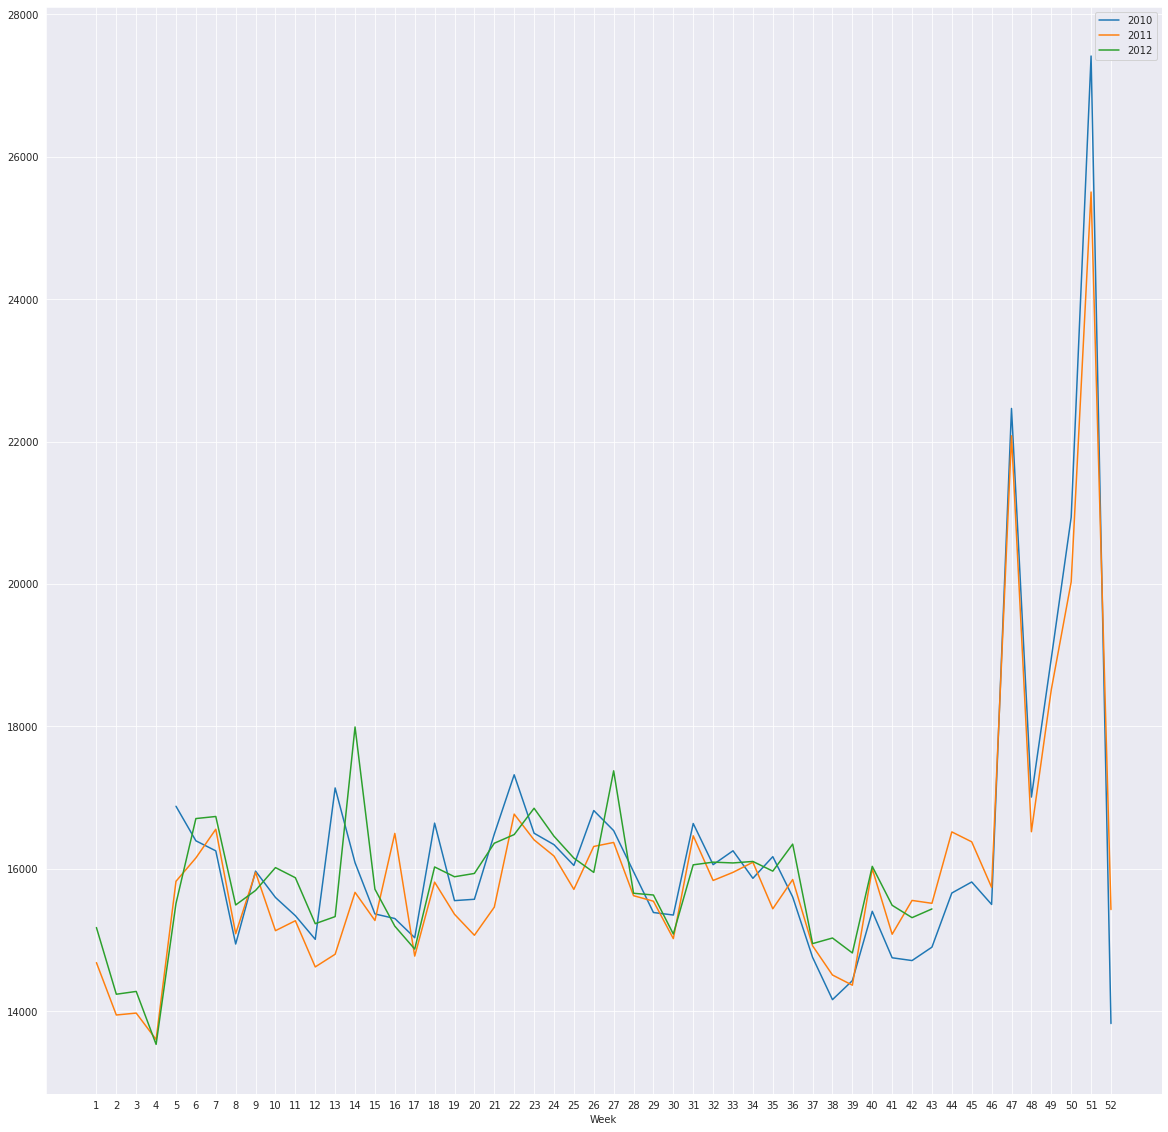

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(20,20))
sns.lineplot(x= WS_10['Weekly_Sales']['mean'].index,y = WS_10['Weekly_Sales']['mean'].values)
sns.lineplot(x=WS_11['Weekly_Sales']['mean'].index, y= WS_11['Weekly_Sales']['mean'].values)
sns.lineplot(x=WS_12['Weekly_Sales']['mean'].index, y = WS_12['Weekly_Sales']['mean'].values)
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010','2011','2012'])
plt.show()

Insights:Weekly sales in week of year distribution shows that sales peak during 47th and 51st week each year.

In [ ]:
df_3=df2.groupby(['Year','Type'])['Weekly_Sales'].mean().reset_index()
df_3['Year'] = df_3['Year'].astype(str)
px.bar(df_3,x='Weekly_Sales',y='Year',color='Type',barmode='group')

Insights: The above plot shows that type A store has maximum amount of weekly sales each year. 

In [ ]:
df_4= df2.groupby(['Year','Month','Type'])[['Temperature','Fuel_Price','CPI','Unemployment','Weekly_Sales']].mean().reset_index()
px.scatter(df_4,x='CPI',y = 'Weekly_Sales',color = 'Type')

Insights:Clear clustering of different types of stores is clearly observed due to avg weekly sales value,as the average consumer price index(CPI) increases the sales from type B and type C stores decrease suggesting these stores are luxury or non essential item stores.If one observes specifically in type A sales region with increase in CPI the amount of avg weekly sales drops suggesting the customer spending is reduced.

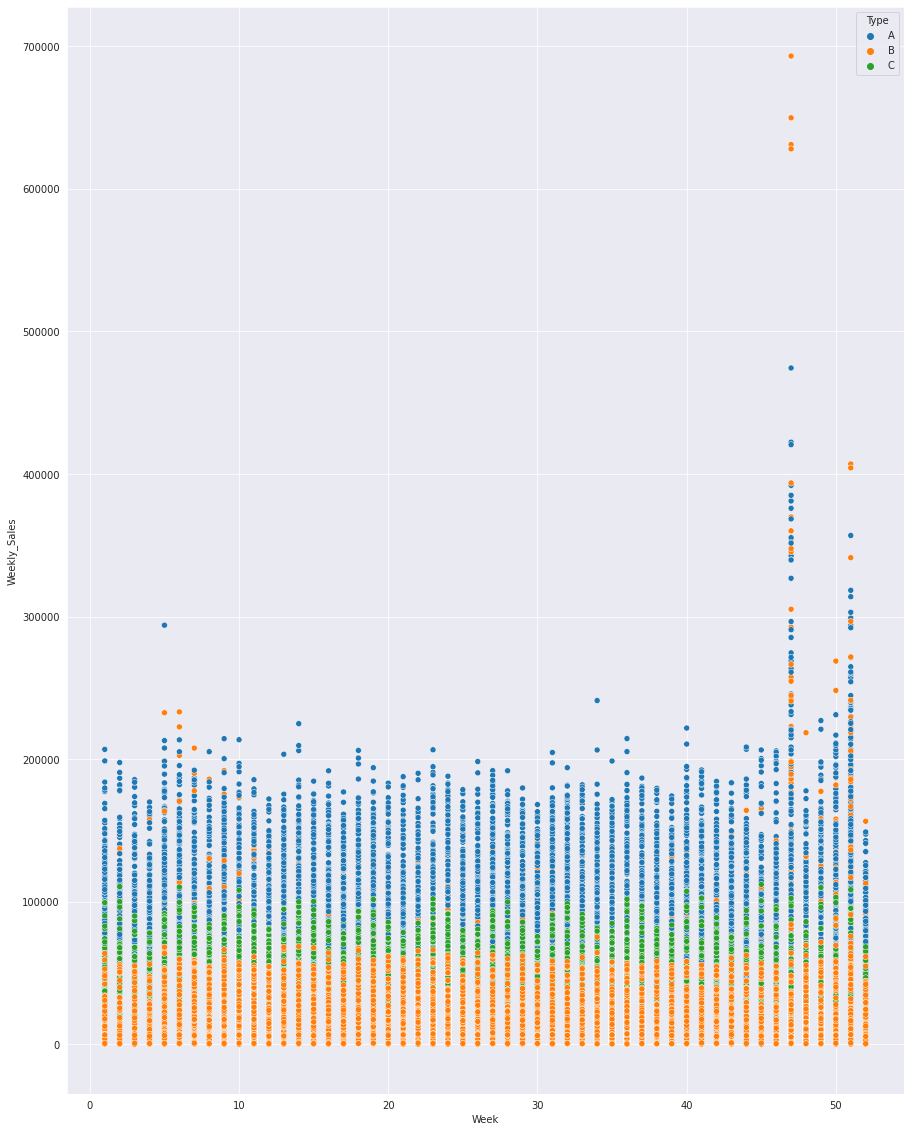

In [ ]:
plt.figure(figsize=(15,20))
sns.scatterplot(data=df2,x='Week',y='Weekly_Sales',hue='Type');

Insights: Weekly sales distribution over weeks in an year suggest that during christmas and thanks giving, the sales from type B store dominate other types weekly sales.

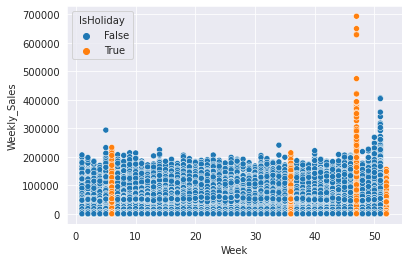

In [ ]:
sns.scatterplot(data = df2,x='Week',y='Weekly_Sales',hue='IsHoliday')

<Figure size 1440x1440 with 0 Axes>

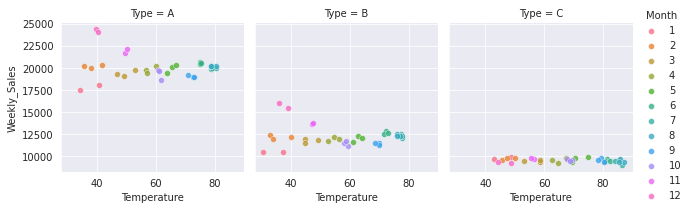

In [ ]:
plt.figure(figsize=(20,20));
sea = sns.FacetGrid(df_4, col = "Type", hue = "Month");
sea.map(sns.scatterplot, "Temperature", "Weekly_Sales", alpha = .8);
sea.add_legend();

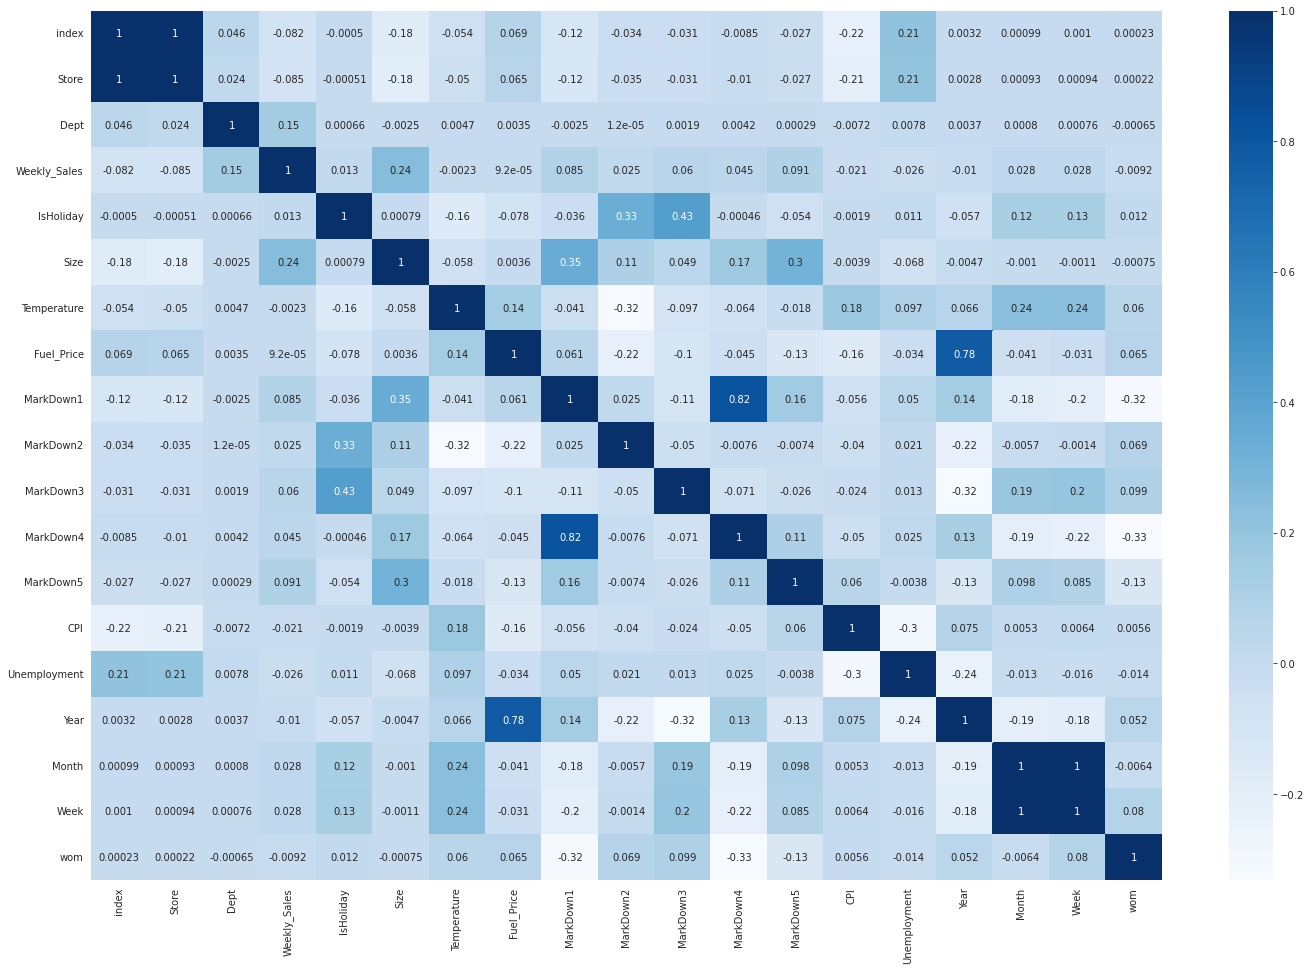

In [ ]:
plt.figure(figsize=(24,16))
sns.heatmap(df2.corr(),cmap ='Blues',annot = True)

In [ ]:
df2 = df2.drop(['index'],axis=1)

Insights: From the exploratory data analysis irrespective of year the weekly sales dependent on mostly on the week of the year with type A store contributing to maximum amount every year.Week 47 and week 51 are weeks with high sales .

# Feature Engineering
From the existing data new feature columns are created which can better establish the relationship between features to improve the machine learning model.

In [ ]:
train_data =df2.copy()

In [ ]:
test_data = test_feature_df.copy()

Based on EDA, it is better to create a new feature for the data which sets the weightage to type of store.

In [ ]:
type_vals = {'A':5, 'B':3 , 'C':1}
train_data['Num_Type']= train_data.Type.map(type_vals)
test_data['Num_Type']=test_data.Type.map(type_vals)

In [ ]:
train_data.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Week,wom,Num_Type
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5,1,5
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,2010,2,6,2,5
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,2010,2,7,3,5
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,2010,2,8,4,5
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,2010,3,9,1,5
5,1,1,2010-03-12,21043.39,False,A,151315,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,2010,3,10,2,5
6,1,1,2010-03-19,22136.64,False,A,151315,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106,2010,3,11,3,5
7,1,1,2010-03-26,26229.21,False,A,151315,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106,2010,3,12,4,5
8,1,1,2010-04-02,57258.43,False,A,151315,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,2010,4,13,1,5
9,1,1,2010-04-09,42960.91,False,A,151315,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808,2010,4,14,2,5


As sales were high in 47th and 51st week new feature column with weightage for these weeks is given.

In [ ]:
train_data['Thanks_Giving'] = train_data.Week.apply(lambda x:1 if x == 47 else 0)
train_data['Christmas'] = train_data.Week.apply(lambda x:1 if x == 51 else 0)

In [ ]:
train_data['IsHoliday'] = train_data['IsHoliday'].apply(lambda x: 1 if x == True else 0)
test_data['IsHoliday'] = test_data['IsHoliday'].apply(lambda x: 1 if x == True else 0)

In [ ]:
test_data['Thanks_Giving'] = test_data.Week.apply(lambda x:1 if x == 47 else 0)
test_data['Christmas'] = test_data.Week.apply(lambda x:1 if x == 51 else 0)

In [ ]:
final_train_df = train_data.copy()
final_train_df = final_train_df.drop(['Date', 'Temperature','Fuel_Price', 'Type', 'MarkDown1', 'MarkDown2', 'MarkDown3',
             'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Month', 'wom','Year' ], axis=1)

In [ ]:
final_test_df = test_data.copy()
final_test_df = final_test_df.drop(['Date', 'Temperature','Fuel_Price', 'Type', 'MarkDown1', 'MarkDown2', 'MarkDown3',
             'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Month', 'wom' ,'Year'], axis=1)

In [ ]:
input_cols = final_train_df.columns.to_list()
input_cols.remove('Weekly_Sales')
target_col= 'Weekly_Sales'


In [ ]:
input_df = final_train_df[input_cols].copy()
targets =final_train_df[target_col].copy()


# Scaling and Encoding
Numerical data should be scaled to provide level playfield to features and encoding of categorical columns to prepare model.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
model = MinMaxScaler().fit(input_df[input_cols])
input_df[input_cols]=model.transform(input_df[input_cols])
final_test_df[input_cols]=model.transform(final_test_df[input_cols])

In [ ]:
from sklearn.model_selection import train_test_split
train_inputs,val_inputs,train_target,val_target = train_test_split(input_df,targets,test_size=0.25,random_state = 30)

In [ ]:
def WAME(df, target, predict):
    weight = df.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weight*abs(target-predict))/(np.sum(weight)), 2)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Randomforest 
Randomforest regressor is used as machine learning model.

In [ ]:
model = RandomForestRegressor(n_jobs=-1,random_state=30).fit(train_inputs,train_target)

In [ ]:
rf = model.predict(train_inputs)

In [ ]:
rf2 = model.predict(val_inputs)

In [ ]:
def test_params(**params):
    model = RandomForestRegressor(random_state=30, n_jobs=-1, **params).fit(train_inputs, train_target)
    WAME_train = WAME(train_inputs, train_target, model.predict(train_inputs))
    WAME_val = WAME(val_inputs, val_target, model.predict(val_inputs))
    return  WAME_train, WAME_val

In [ ]:
def test_param_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        WAME_train, WAME_val= test_params(**params)
        train_errors.append(WAME_train)
        val_errors.append(WAME_val)
    plt.figure(figsize=(10,10))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'g-o')
    plt.plot(param_values, val_errors, 'c-o')
    plt.xlabel(param_name)
    plt.ylabel('WAME')
    plt.legend(['Training', 'Validation'])

Hypermameters are experimented with different values to optimise the model avoiding overfitting of the data

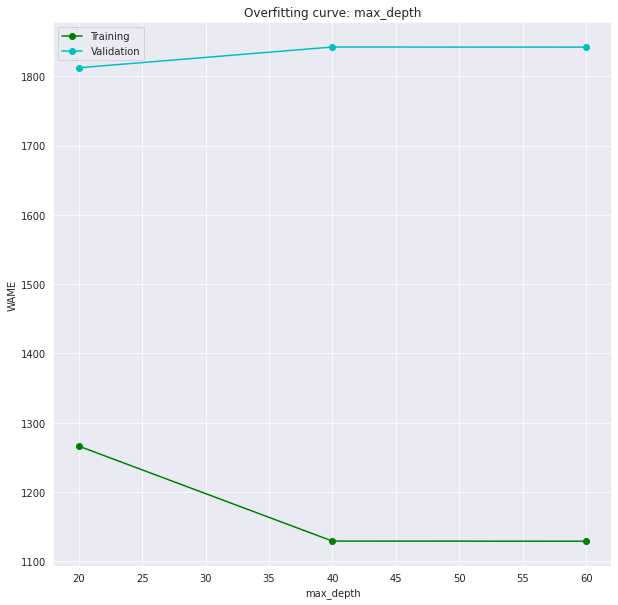

In [ ]:
test_param_plot('max_depth',[20,40,60])

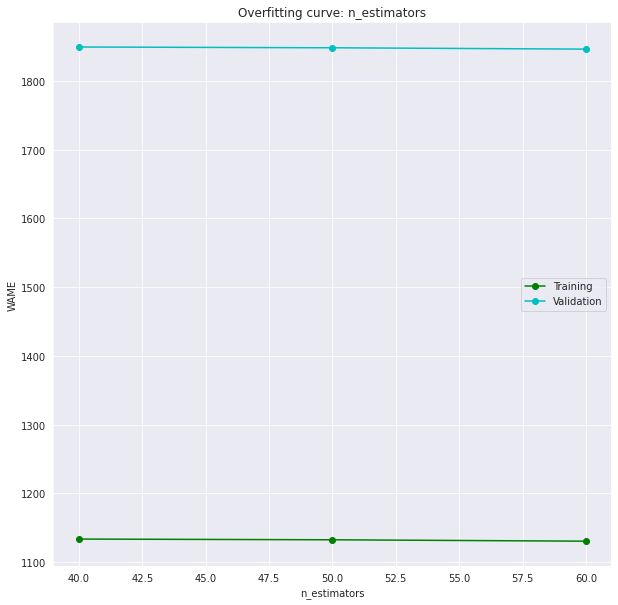

In [ ]:
test_param_plot('n_estimators',[40,50,60])

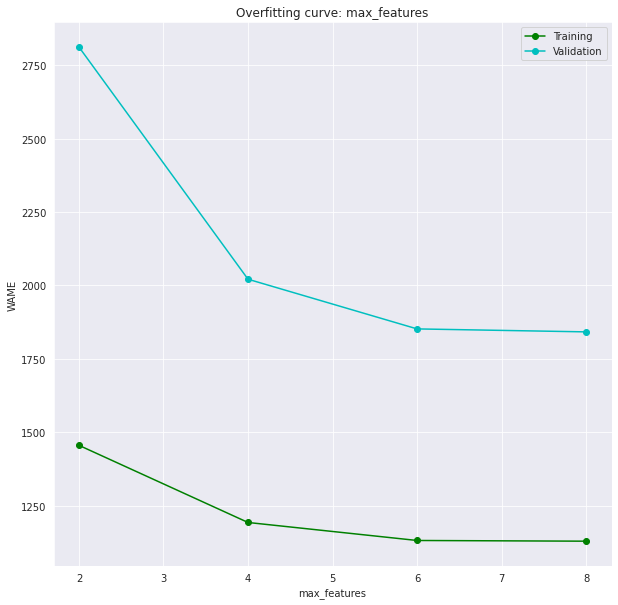

In [ ]:
test_param_plot('max_features',[2,4,6,8])

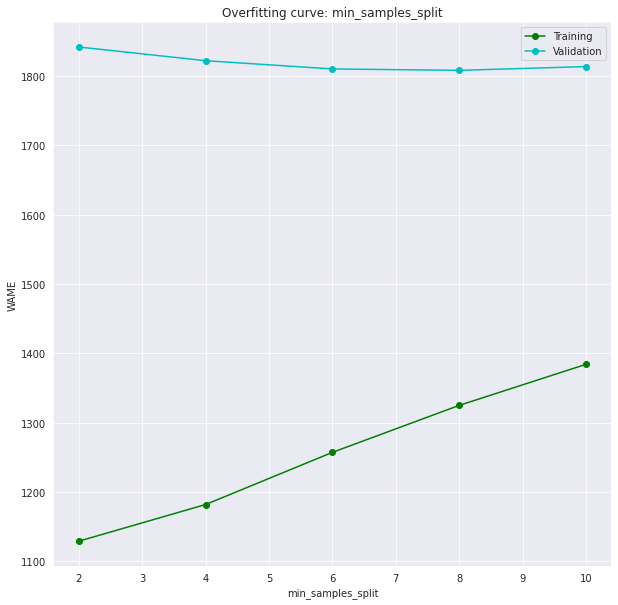

In [ ]:
test_param_plot('min_samples_split',[2,4,6,8,10])

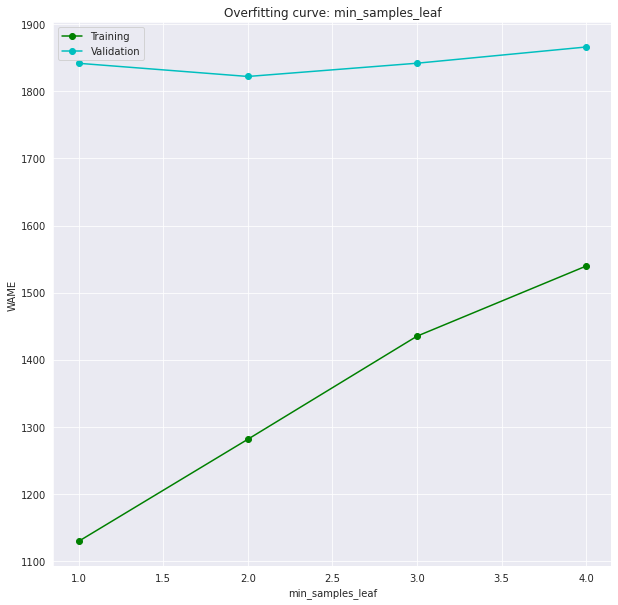

In [ ]:
test_param_plot('min_samples_leaf',[1,2,3,4])



In [ ]:
import jovian
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [ ]:
rff = RandomForestRegressor(n_jobs=-1,random_state=30,  
                            n_estimators=40,
                            max_depth = 20,
                            max_features=8,
                            min_samples_split = 8, 
                            min_samples_leaf = 2)

In [ ]:
rff.fit(train_inputs,train_target)

RandomForestRegressor(max_depth=20, max_features=8, min_samples_leaf=2,
                      min_samples_split=8, n_estimators=40, n_jobs=-1,
                      random_state=30)

In [ ]:
rff_train_pred = rff.predict(train_inputs)


In [ ]:
rff_val_pred =rff.predict(val_inputs)

In [ ]:
WAME_train_rff = WAME(train_inputs, train_target,rff_train_pred)
WAME_val_rff = WAME(val_inputs, val_target, rff_val_pred)

In [ ]:
print('Train WAME: {}, Val WAME: {}'.format(WAME_train_rff, WAME_val_rff))

Train WAME: 1474.3, Val WAME: 1851.13


In [ ]:
test_pred_rand = rff.predict(final_test_df)

In [ ]:
importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_df


,feature,importance
1,Dept,0.634251
3,Size,0.208763
0,Store,0.073717
4,Week,0.037516
6,Thanks_Giving,0.021082
5,Num_Type,0.014759
7,Christmas,0.008695
2,IsHoliday,0.001217


# XG Boost
XGBRegressor model is used as the other machine learning model.

In [ ]:
from xgboost import XGBRegressor

In [ ]:
model = XGBRegressor(random_state=30, n_jobs=-1, n_estimators=500, max_depth=10).fit(train_inputs,train_target)

In [ ]:
Xf_train = model.predict(train_inputs)

In [ ]:
Xf_val = model.predict(val_inputs)

In [ ]:
WAME_train_Xf = WAME(train_inputs, train_target,Xf_train)
WAME_val_Xf = WAME(val_inputs, val_target, Xf_val)

In [ ]:
print('Train WAME: {}, Val WAME: {}'.format(WAME_train_Xf, WAME_val_Xf))

Train WAME: 1126.07, Val WAME: 1770.19


In [ ]:
def test_params(**params):
    model = XGBRegressor(random_state=30, n_jobs=-1,n_estimators= 300, **params).fit(train_inputs, train_target)
    WAME_train = WAME(train_inputs, train_target, model.predict(train_inputs))
    WAME_val = WAME(val_inputs, val_target, model.predict(val_inputs))
    print('Train WAME: {}, Val WAME: {}'.format(WAME_train,WAME_val))

In [ ]:
test_params(max_depth = 20)

Train WAME: 1007.2, Val WAME: 1960.01


In [ ]:
test_params(max_depth = 10,learning_rate=0.2)


Train WAME: 1264.02, Val WAME: 1688.55


In [ ]:
test_params(max_depth = 10,learning_rate=0.4)


Train WAME: 1165.77, Val WAME: 1764.15


In [ ]:
xff = XGBRegressor(random_state=30, n_jobs=-1,n_estimators= 300,max_depth = 10,learning_rate=0.2).fit(train_inputs, train_target)


In [ ]:
Sales_predict = xff.predict(final_test_df)

In [ ]:
importance_XG_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': xff.feature_importances_
}).sort_values('importance', ascending=False)

In [ ]:
importance_XG_df

,feature,importance
6,Thanks_Giving,0.342777
1,Dept,0.214852
5,Num_Type,0.185234
3,Size,0.140206
7,Christmas,0.066866
0,Store,0.036989
4,Week,0.008937
2,IsHoliday,0.004140


# Submission
Using XG boosting machine learning algorithm the test values are predicted as its error was less compared to randomforest for training and validation data

In [ ]:
submission_df

,Id,Weekly_Sales
0,1_1_2012-11-02,36580.421875
1,1_1_2012-11-09,19474.406250
2,1_1_2012-11-16,19413.191406
3,1_1_2012-11-23,19903.232422
4,1_1_2012-11-30,24158.068359
...,...,...
115059,45_98_2013-06-28,436.647705
115060,45_98_2013-07-05,1260.194824
115061,45_98_2013-07-12,569.143372
115062,45_98_2013-07-19,485.694580


In [ ]:
submission_df['Weekly_Sales'] = Sales_predict
submission_df

,Id,Weekly_Sales
0,1_1_2012-11-02,36580.421875
1,1_1_2012-11-09,19474.406250
2,1_1_2012-11-16,19413.191406
3,1_1_2012-11-23,19903.232422
4,1_1_2012-11-30,24158.068359
...,...,...
115059,45_98_2013-06-28,436.647705
115060,45_98_2013-07-05,1260.194824
115061,45_98_2013-07-12,569.143372
115062,45_98_2013-07-19,485.694580


In [ ]:
submission_df.to_csv('submission.csv',index=False)

In [ ]:
from google.colab import files 
files.download('submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Summary and Future work
##Summary:
The weekly sales of walmart were predicted for the given testset using multiple regression models and the model with least error is used as the final test predictions.To select the important features exploratory data analysis is performed on the data downloaded from kaggle dataset.

##Future work:
There are several other parameters like markdown which can be explored further to improve the model's accuracy and other models of regression can also be used on the present dataset to compare individual accuracies.


# References:
##https://www.kaggle.com/code/yasirhussain1987/eda-and-store-sales-predictions-using-xgb
##https://www.kaggle.com/code/maxdiazbattan/wallmart-sales-top-3-eda-feature-engineering
##https://www.kaggle.com/code/andredornas/tp2-walmart-sales-forecast
